## **Custom datasets**

Author: Alejandro Meza Tudela

In this notebook, we are going to see how to implement our custom datasets.

Some libraries that can be useful depending on the use case:
- vision: TorchVision -->torchvision.datasets
- text: TorchText --> torchtext.datasets
- audio: TorchAudio --> torchaudio.datasets
- recommendation: TorchRec --> torchrec.datasets




## 0. Importing pytorch and setting agnostic code

In [ ]:
import torch
from torch import nn
torch.__version__

'2.5.1+cu121'

In [ ]:
#set up device-agnositc code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 1. Get data

Food101 starts 101 different classes of food, and 1000 images per class (750 are for training, and the rest for testing).

Why do this?

When starting in ML projects, it's important to try thing on small datasets, and then scale when necessary.

In [ ]:
import requests
import zipfile
from pathlib import Path

#setup a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#if the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

#download data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

#unzip the data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## 2.Becoming one with the data


In [ ]:
import os

def walk_through_dir(dir_path):
  """
  Walks
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [ ]:
#set up train and test part
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize the data

Random image path: data/pizza_steak_sushi/train/steak/2707522.jpg
Image class: steak
Image height: 512
Image width: 512


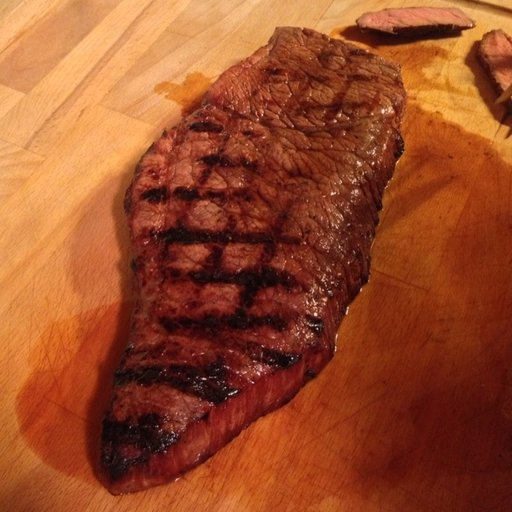

In [ ]:
import random
from PIL import Image

#set the seed
random.seed(42)

#1.get image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

#2. pick a random image
random_image_path = random.choice(image_path_list)

#3. get image class from path name
image_class = random_image_path.parent.stem

#4. open image
img = Image.open(random_image_path)

#5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

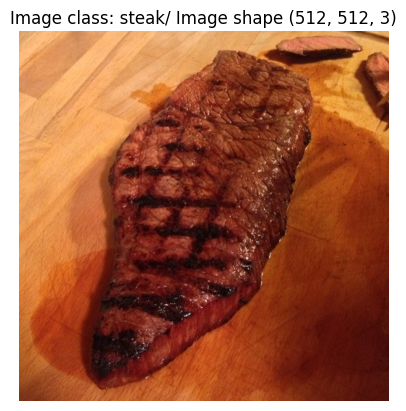

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}/ Image shape {img_as_array.shape}")
plt.axis(False)

So, we can see that our image is a 512x512 image, and has 3 color channels.

## 3.Transforming our data

Before we can use our image data, we have to convert the data to tensors. And obviouly, we are going to have to use some of the datasets modules.

In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

## 3.1 Transform data into tensors

Transforms helps you get your images ready to be manipulated for your model.

In [ ]:
data_transfrom = transforms.Compose([
    #resize the images to a fixed size
    transforms.Resize((64, 64)),
    #flip the images randomly
    transforms.RandomHorizontalFlip(p=0.5),
    #convert the images to a tensor
    transforms.ToTensor() #--> need a numpy ndarray as input
])

In [ ]:
#just an example about what can we do
data_transfrom(img).shape

torch.Size([3, 64, 64])

In [ ]:
def plot_transformed_images(image_paths:list,
                            transform,
                            n=3,
                            seed=42):
  """
  Plots a series of random images from image_paths
  """
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis(False)

      #matplotlib requires to have the color channel in the last position --> permute is a must
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Size: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

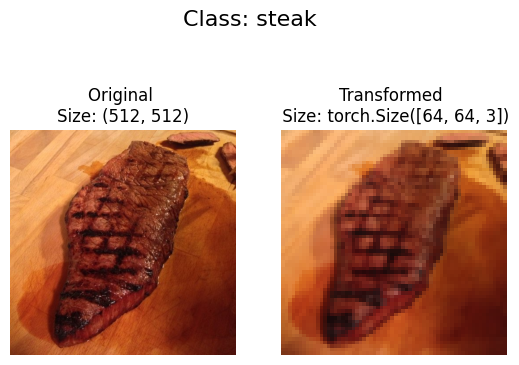

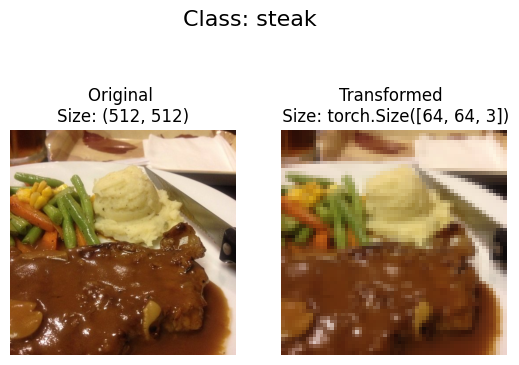

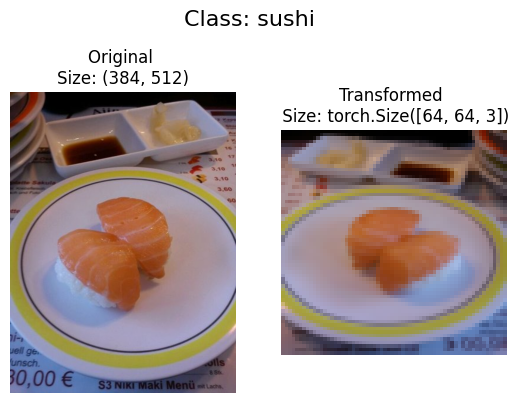

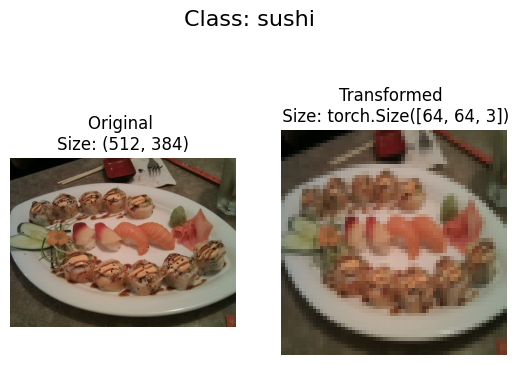

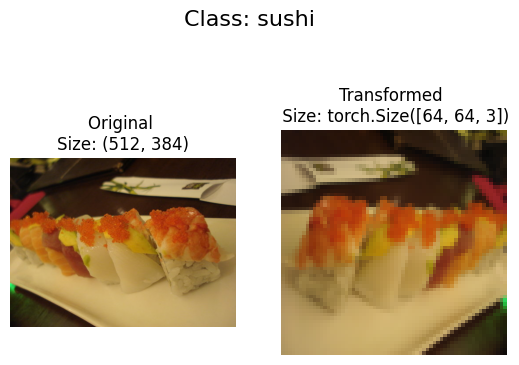

In [ ]:
plot_transformed_images(image_path_list,
                        data_transfrom,
                        5,
                        )

As we can see, the smaller the image is, the lower the image resolution is.

## 4. Option 1: Loading image data using 'ImageFolder'

We can load image classification data using 'torchvision.datasets.ImageFolder'.

In [ ]:
data_transfrom = transforms.Compose([
    #resize the images to a fixed size
    transforms.Resize((64, 64)),
    #flip the images randomly
    transforms.RandomHorizontalFlip(p=0.5),
    #convert the images to a tensor
    transforms.ToTensor() #--> need a numpy ndarray as input
])

In [ ]:
#Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                   transform=data_transfrom,
                                   target_transform = None #transform for the label/target
                                   )
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transfrom,
                                  target_transform = None #transform for the label/target
                                  )

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
#get class names as a list
class_names = train_data.classes
print(class_names)

#get class names as a dictionary
class_dict = train_data.class_to_idx
print(class_dict)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [ ]:
#check the lengths of our datasets
len(train_data), len(test_data)

(225, 75)

In [ ]:
#in order to check the samples
train_data.samples[:5]

[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0)]

Image shape: torch.Size([3, 64, 64]), Image label 0
torch.Size([64, 64, 3])


Text(0.5, 1.0, 'Class: pizza')

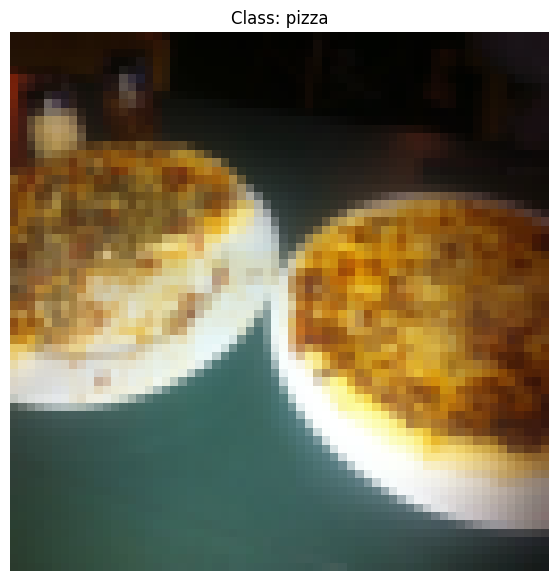

In [ ]:
#Rearrange the order of dimensions
img, label = train_data[0][0], train_data[0][1]
print(f"Image shape: {img.shape}, Image label {label}")
img_permute = img.permute(1, 2, 0)
print(f'{img_permute.shape}')

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(f"Class: {class_names[label]}")

# 4.1 Turn load images into a dataloader

A dataloader is going to help to us to turn our dataset into iterables. Also, its going to be very easy to define some iterables.


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
print(train_data)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In order to convert our data into dataloaders, you have to notice that is mandatory to have defined some datasets previously.

In [ ]:
import os
os.cpu_count()

2

In [ ]:
#turn train and test datasets into dataloader\
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True) #shuffle the data --> in order to prevents the model to know the sequence of the data
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x785a559a43a0>,
 <torch.utils.data.dataloader.DataLoader at 0x785a559c03a0>)

DataLoader num_workers Parameter Overview

Definition: num_workers specifies the number of subprocesses to use for data loading in PyTorch's DataLoader.

Effects of Changing num_workers:

Parallel Data Loading: Increases the number of subprocesses to load data simultaneously.

Potential Speedup: Can lead to faster training times if data loading is a bottleneck, especially with large datasets or intensive preprocessing.

Memory Usage: More workers increase memory consumption, as each worker h
olds its own copy of the dataset. Monitor for potential memory issues.

I/O Operations: More workers can reduce the waiting time for I/O operations, improving loading speed if data is stored on disk.

Recommendation:
If data loading is slow, experiment with increasing num_workers (e.g., from 1 to 2 or higher).
Monitor resource usage to avoid running out of memory, especially in environments with limited resources like Google Colab.

In [ ]:
len(train_data),len(train_dataloader)

(225, 8)

In [ ]:
len(test_data),len(test_dataloader)

(75, 3)

## OPTION: Loading image data with a custom dataset

- Want to be able to load images from files
- Want to be able to load existing images
- Want to be able to get classes as dictionary from the dataset

PROS:
- Can create a Dataset out of almost anything
- Not limited to Pytorch

CONS:
- Custom Datasets requires to create more code, and also implies some performance issues.


In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper function to get classes names

We want a function to:
- get the classes name using os.scandir() to traverse a target dictionary
- raise an error if the class names are not found
- turn the class name into a dict and a list and return them

In [ ]:
target_directory = train_dir
print(f'Target dir: {target_directory}')

class_names = []
for entry in os.scandir(target_directory):
  if entry.is_dir():
    class_names.append(entry.name)
print(f'Class names: {class_names}')

Target dir: data/pizza_steak_sushi/train
Class names: ['steak', 'sushi', 'pizza']


In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Finds the class folder names in a target directory
  and creates a index to folder name mapping
  """
  class_names = []
  for entry in os.scandir(directory):
    if entry.is_dir():
      class_names.append(entry.name)

  if not class_names:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}")

  dictionary = {class_name: idx for idx, class_name in enumerate(class_names)}
  return class_names, dictionary

In [ ]:
find_classes(target_directory)

(['steak', 'sushi', 'pizza'], {'steak': 0, 'sushi': 1, 'pizza': 2})

### Create a custom 'Dataset' to replicate image folder

- subclass 'torch.utils.data.Dataset'
- init our subclass with a target directory
- create several attributes:
  * paths
  * transform
  * classes
  * class_to_idx
- create a function to load_images()
- overwrite the len() method to return the lenght of the dataset
- overwrite the getitem() method to return a given sample when pass an index

In [ ]:
import pathlib
from typing import Tuple
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

def find_classes(target_dir: str):
    """Finds the class names and their corresponding indices."""
    classes = [d.name for d in pathlib.Path(target_dir).iterdir() if d.is_dir()]
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

# Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    def __init__(self, target_dir: str, transform: transforms.Compose = None):
        # Initialize our custom dataset
        self.target_dir = target_dir
        self.transform = transform
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        self.classes, self.class_to_idx = find_classes(target_dir)

    # Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens and transforms an image"
        image_path = self.paths[index]
        return Image.open(image_path).convert("RGB")  # Convert to RGB

    # Overwrite len method
    def __len__(self):
        return len(self.paths)

    # Overwrite __getitem__ method: return image and label
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        image = self.load_image(index)
        class_name = self.paths[index].parent.name

        # Transform if necessary
        if self.transform:
            image = self.transform(image)

        return image, self.class_to_idx[class_name]

In [ ]:
#create a transform
from torchvision import transforms
train_transform = transforms.Compose([
    #resize the images to a fixed size
    transforms.Resize((64, 64)),
    #flip the images randomly
    transforms.RandomHorizontalFlip(p=0.5),
    #convert the images to a tensor
    transforms.ToTensor() #--> need a numpy ndarray as input
])

test_transfomr = transforms.Compose([
    #resize the images to a fixed size
    transforms.Resize((64, 64)),
    #convert the images to a tensor
    transforms.ToTensor() #--> need a numpy ndarray as input
])

In [ ]:
train_data_custom = ImageFolderCustom(train_dir, train_transform)
test_data_custom = ImageFolderCustom(test_dir, test_transfomr)

In [ ]:
train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x785a4e4ee3e0>,
 <__main__.ImageFolderCustom at 0x785a4e4ecf40>)

In [ ]:
train_data_custom.classes, train_data_custom.class_to_idx

(['steak', 'sushi', 'pizza'], {'steak': 0, 'sushi': 1, 'pizza': 2})

In [ ]:
#check for equallity between original ImageFolder Dataset and ImageFolder custom dataset
train_data.classes == train_data_custom.classes

False

### Create a function to display random images

1. Take in a 'Dataset' and a number of other parameterhs, such as class names and how many images to visualize
2. Max number of images to display
3. Set the random seed for reproducibility
4. Get a list of random samples from the target dataset
5. set matplotlib plot
6. Loop through the random samples and plot them
7. Make sure dimensions of images line up with matplot lib

In [ ]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n:int=10,
                          display_shape: bool = True,
                          seed: int =None):
  #adjust display if necessary
  if n>10:
    n=10
    display_shape = False
  #set the seed
  if seed:
    random.seed(seed)
  #get the random samples index
  random_samples_idx = random.sample(range(len(dataset)), k=n)
  #set-up plot
  plt.figure(figsize=(16, 8))
  #loop through indexes and plot with matplotlib
  for i, idx in enumerate(random_samples_idx):
    img, label = dataset[idx][0], dataset[idx][1]
    #adjust tensor dimensions for plotting
    targ_image_adjust = img.permute(1, 2, 0)
    #plot the image
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    if classes:
      plt.title(f"Class: {classes[label]}")
    else:
      plt.title(f"Class: {label}")
    plt.axis(False)

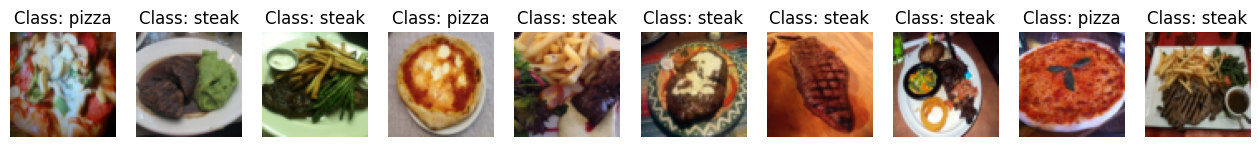

In [ ]:
display_random_images(
    train_data_custom,
    classes=train_data_custom.classes,
    n=10,
    seed=42
)

### Turn custom loaded images into dataloaders

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              shuffle=True) #shuffle the data --> in order to prevents the model to know the sequence of the data
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x785a4e3291e0>,
 <torch.utils.data.dataloader.DataLoader at 0x785a4e3290c0>)

In [ ]:
#get image and label from custom dataloader
img, label = next(iter(train_dataloader_custom))
print(f'Image shape: {img.shape}, Label shape: {label.shape}')

Image shape: torch.Size([32, 3, 64, 64]), Label shape: torch.Size([32])


## Data augementation

Is the process of artificially adding diversity to your training data. For example, rotate the original image, or apply zoom-in transformations.

#### trivial augment

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=10),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
image_path_list = list(pathlib.Path(train_dir).glob("*/*.jpg"))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/train/steak/3142674.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2629750.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1976160.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/100135.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/214320.jpg')]

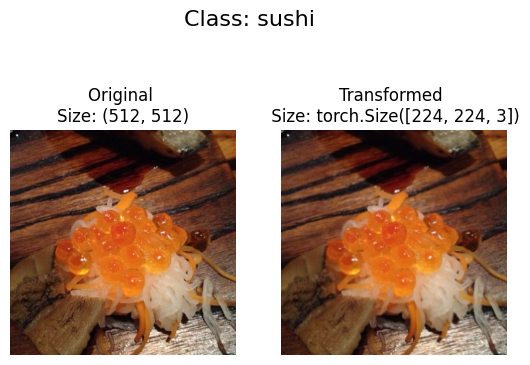

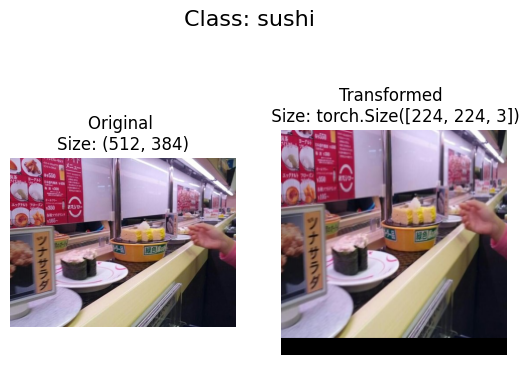

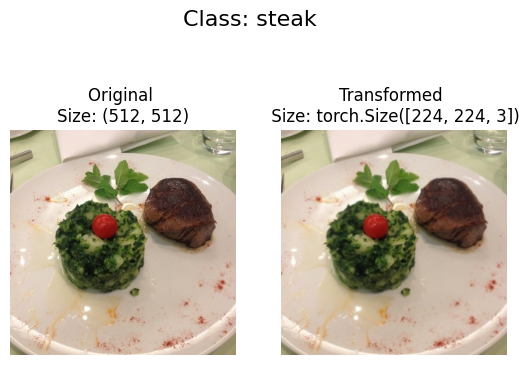

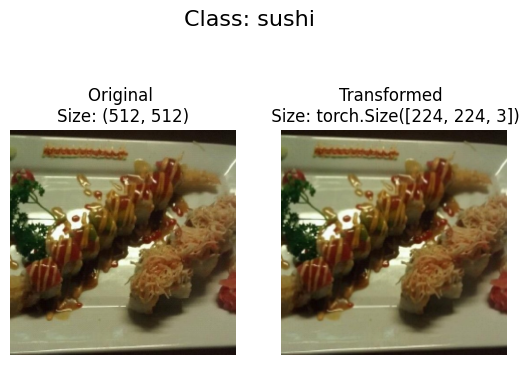

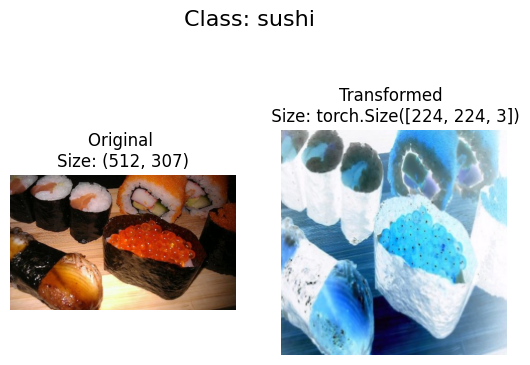

In [ ]:
plot_transformed_images(image_path_list,
                        train_transform,
                        n=5,
                        seed=None
                        )

## Model 0: TinyVGG without data augmentation

Let's replicate the TinyVGG architecture.



In [ ]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
from torchvision import datasets
#load datasets
train_dat_simple = datasets.ImageFolder(root=train_dir,
                                   transform=simple_transform
                                   )
test_dat_simple = datasets.ImageFolder(root=test_dir,
                                   transform=simple_transform
                                   )
#turn the datasets into dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

#create train data loader
train_dataloader_simple = DataLoader(dataset=train_dat_simple,
                              batch_size=BATCH_SIZE,
                                     shuffle=True,
                              num_workers=NUM_WORKERS)

In [ ]:
#create test data loader
test_dataloader_simple = DataLoader(dataset=test_dat_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                     num_workers=NUM_WORKERS)

In [ ]:
#Create a convolutional neuronal network
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
      super().__init__()
      #a block is a group of layers
      self.conv_block_1 = nn.Sequential(
          #create a conv-layer
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(), #layer to apply non-linearity
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(), #layer to apply non-linearity
          nn.MaxPool2d(kernel_size=2,
                       stride=2) #default stride value is the same as kernel size
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(), #layer to apply non-linearity
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(), #layer to apply non-linearity
          nn.MaxPool2d(kernel_size=2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          #there is a trick to calculate this part
          nn.Linear(in_features=hidden_units*169,  #we have to adapt this value depending the output of layer 2
                    out_features=output_shape)
      )

    def forward(self, x):
      x = self.conv_block_1(x)
      #print(f'Shape of block 1: {x.shape}')
      x = self.conv_block_2(x)
      #print(f'Shape of block 2: {x.shape}')
      x = self.classifier(x)
      #print(f'Shape of classifier: {x.shape}')
      return x
      #return self.classifier(self.conv_block_2(self.conv_block_1(x))) --> faster method --> avoid transportation of data through memory


In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)
                  ).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### Try a forward pass to test the model

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
#try a forward pass
model_0(image_batch)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.9347e-02,  3.1597e-03,  7.4474e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.1068e-02, -2.6110e-03,  1.0277e-02],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 1.9275e-02, -1.7611e-04,  8.9663e-03],
        [ 1.9972e-02, -2.9622e-03,  8.2557e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2589e-02, -3.4084e-03,  1.0640e-02],
        [ 2.0182e-02, -2.1775e-03,  9.5757e-03],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 1.7433e-02

**So, we obtained a run time error: untimeError: mat1 and mat2 shapes cannot be multiplied (32x2560 and 10x3). It's time to change the dimensions of the final layer!!

## Use torch.info to obtain information about our model/doubts

In [ ]:
pip install torchinfo

In [ ]:
import torchinfo
from torchinfo import summary

In [ ]:
#this library do a forward pass agaaints the model that we have defined
summary(model=model_0,
        input_size=(32, 3, 64, 64)
        )

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

## Create train and test loops function

In [ ]:
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device):

  #put the model on train model
  model.train()

  #add evaluation metrics
  train_loss, train_acc = 0, 0

  #TRAIN LOOP
  for batch, (X, y) in enumerate(dataloader):
    #send data to device
    X, y = X.to(device), y.to(device)

    #perform forward pass
    y_pred = model(X)

    #calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    #optimize zero grad
    optimizer.zero_grad()

    #perform backpropagation
    loss.backward()

    #optimizer step
    optimizer.step()

    #calculate accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  #adjust metrics to get the average
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device):

  #put the model on train model
  model.eval()

  #add evaluation metrics
  test_loss, test_acc = 0, 0

  #TEST LOOP
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      #1. Forward pass
      test_pred_logits = model(X)

      #2. Calculate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      #3. Calculate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

  #adjust metrics to get the average
  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)
  return test_loss, test_acc

## Create a train function that combines train_step() and test_step()

In [ ]:
from tqdm.auto import tqdm

#1.Create a train function that takes in various model parameters
def train(model:torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn,
          epochs: int,
          device: torch.device):

  #2.Creates empty result dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
             }

  #3.Loop though train and testing steps
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device)

    #4.Obtain the results and save them in a dictionary
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

## Train and evaluate our model

In [ ]:
torch.manual_seed(42)#just for reproducibility
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)
                  ).to(device)

In [ ]:
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
number_of_epochs = 5
model_0_results = train(model_0,train_dataloader_simple,test_dataloader_simple,optimizer,loss_fn,number_of_epochs,device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011
Epoch: 2 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417
Epoch: 3 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0808 | Test acc: 0.4924
Epoch: 4 | Train loss: 1.0842 | Train acc: 0.3984 | Test loss: 1.0608 | Test acc: 0.5833
Epoch: 5 | Train loss: 1.0662 | Train acc: 0.4141 | Test loss: 1.0654 | Test acc: 0.5644


As you can see, the results are no that good, so there are some ways to improve our model performance.

- Increase the layers of the model
- Add hidden units of the model
- Increase the number of epochs
- Change the activation functions
- Change the learning rate
- Change the loss function (in our class, cross entropy class is good enough in a multiclass problem)

## Plot the obtained results

A **loss curve** is a way to track the progress of the model over a certain period of time T. Is one of the most popular methods to track a model.

In [ ]:
#get the model_0 results key
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results):

  train_loss = results['train_loss']
  test_loss = results['test_loss']

  train_accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  #obtain the number of epochs that we use to obtain the metrics
  epochs = range(len(train_loss))

  plt.figure(figsize=(15, 7))

  #plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_accuracy, label='train_acc')
  plt.plot(epochs, test_accuracy, label='test_acc')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

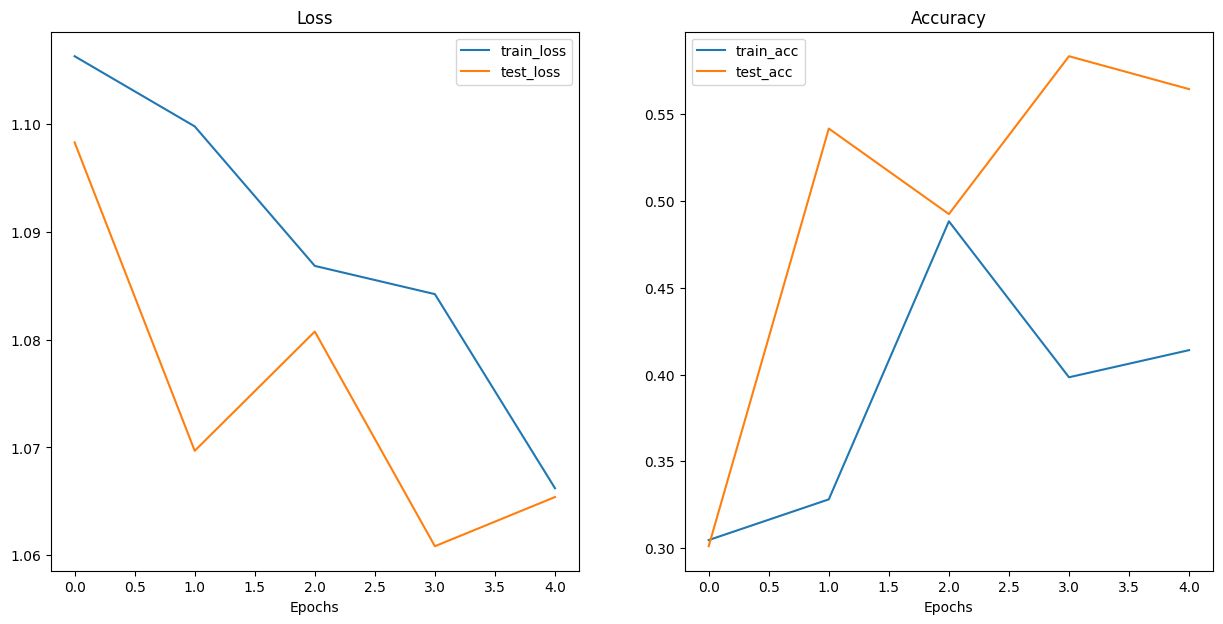

In [ ]:
plot_loss_curves(model_0_results)

General tips:

- HOW TO DEAL WITH OVERFITTING: get more data, apply data-augmentation, better data, use transfer learning, simplify your model, **use learning rate-decay(decay learning rate over time)**,
use early stopping

- HOW TO DEAL WITH UNDERFITTING: add more layers, tweak learning rate, train for longer, use transfer learning, use less regularization


It seems that our model suffers of underfitting. So, let's try to solve the problem!

## Model TinyVGG with data augmentation

Let's add data augmentation techniques to try to improve the model's performance.

In [ ]:
#create training transform with TrivialAugment
from torchvision import transforms

train_transform_aug = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_aug = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
#lets create data loaders
from torchvision import datasets

train_data_aug = datasets.ImageFolder(root=train_dir,
                                   transform=train_transform_aug
                                   )
test_data_aug = datasets.ImageFolder(root=test_dir,
                                   transform=test_transform_aug
                                   )

In [ ]:
#turn datasets in data-loader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_aug = DataLoader(dataset=train_data_aug,
                              batch_size=BATCH_SIZE,
                                     shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader_aug = DataLoader(dataset=test_data_aug,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                     num_workers=NUM_WORKERS)

In [ ]:
torch.manual_seed(42)#just for reproducibility
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_aug.classes)
                  ).to(device)

optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)
loss_fn = nn.CrossEntropyLoss()

number_of_epochs = 5
model_1_results = train(model_1,train_dataloader_aug,test_dataloader_aug,optimizer,loss_fn,number_of_epochs,device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.1069 | Train acc: 0.3047 | Test loss: 1.0993 | Test acc: 0.2708
Epoch: 2 | Train loss: 1.1019 | Train acc: 0.3203 | Test loss: 1.0719 | Test acc: 0.5417
Epoch: 3 | Train loss: 1.0917 | Train acc: 0.4375 | Test loss: 1.0846 | Test acc: 0.4924
Epoch: 4 | Train loss: 1.0915 | Train acc: 0.3125 | Test loss: 1.0678 | Test acc: 0.5833
Epoch: 5 | Train loss: 1.0862 | Train acc: 0.3594 | Test loss: 1.0751 | Test acc: 0.5331


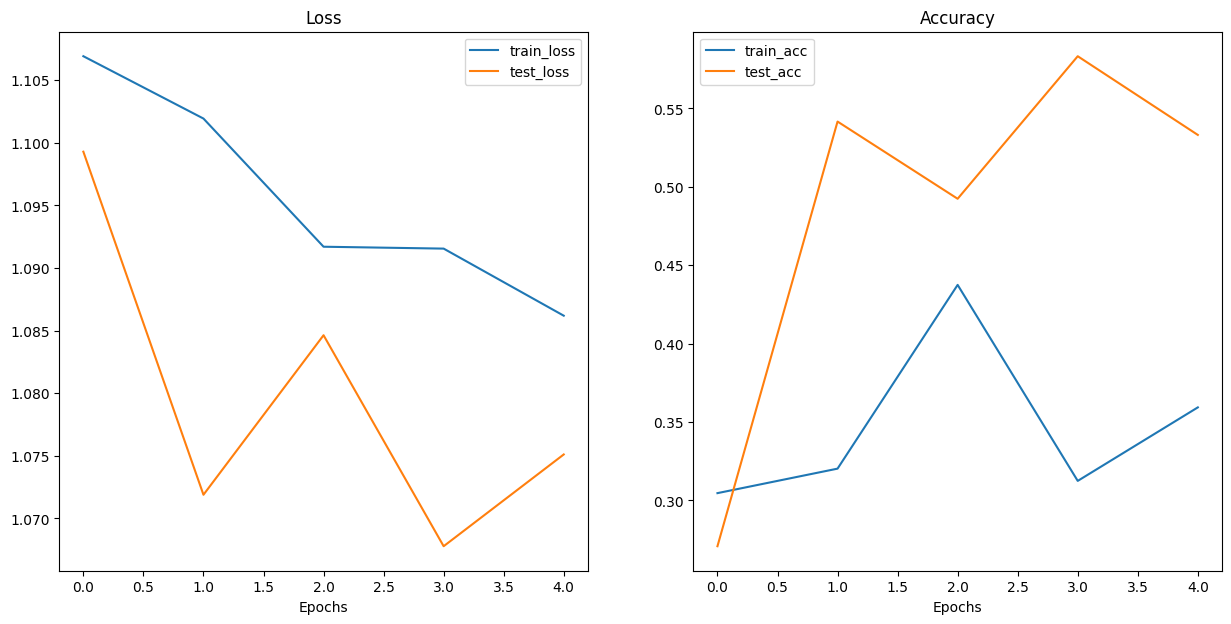

In [ ]:
plot_loss_curves(model_1_results)

## Compare model results

1. Hard coding
2. Pytorch + Tensorboard
3. Weights & biases
4. MLFLOW --> extensions

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.106319   0.304688   1.098321  0.301136
1    1.099806   0.328125   1.069690  0.541667
2    1.086854   0.488281   1.080757  0.492424
3    1.084233   0.398438   1.060832  0.583333
4    1.066216   0.414062   1.065396  0.564394

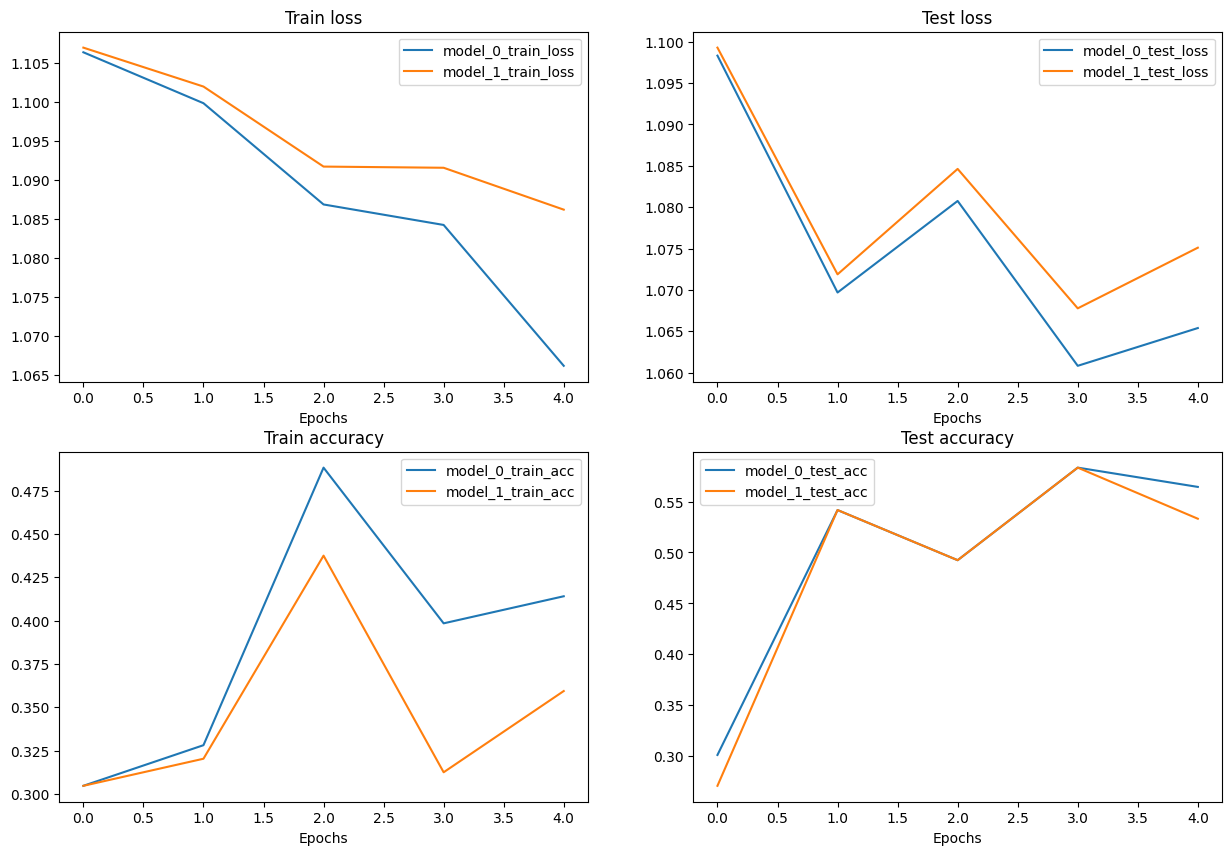

In [ ]:
#plots the results
plt.figure(figsize=(15, 10))

#get number of epochs
epochs = range(len(model_0_df))

#plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df['train_loss'], label='model_0_train_loss')
plt.plot(epochs, model_1_df['train_loss'], label='model_1_train_loss')
plt.title('Train loss')
plt.xlabel('Epochs')
plt.legend()

#plot train loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df['test_loss'], label='model_0_test_loss')
plt.plot(epochs, model_1_df['test_loss'], label='model_1_test_loss')
plt.title('Test loss')
plt.xlabel('Epochs')
plt.legend()

#plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df['train_acc'], label='model_0_train_acc')
plt.plot(epochs, model_1_df['train_acc'], label='model_1_train_acc')
plt.title('Train accuracy')
plt.xlabel('Epochs')
plt.legend()

#plot test accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df['test_acc'], label='model_0_test_acc')
plt.plot(epochs, model_1_df['test_acc'], label='model_1_test_acc')
plt.title('Test accuracy')
plt.xlabel('Epochs')
plt.legend()

It seem's that if we made our models more complex, it could be possible to improve the obtained results. For now, we are going to skip this part and focus on try to make predictions over the data that we already have.

## Making predictions over custom data

We are going to focus on make predictions over the data that we have.

In [ ]:
#download custom image
import requests

#setup custom image
custom_image_path = data_path / '04-pizza-dad.jpeg'

#download the image if do not exist
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    img_url = 'https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/data/04-pizza-dad.jpeg'
    request = requests.get(img_url)
    print(f'Downloading {img_url}')
    f.write(request.content)
else:
  print('Image already exists')

## Loading a custom image with Pytorch

We have to transform the image to tensor format, and also be sure that this image has an appropiate size (basically, it's mandatory that the new image should have the same properties as the images that the model used in it's training phase).

- Tensor (float32)
- 64x64x3
- On the right device

For doing this, we are going to use the library **torchvision.io.read_image**.

This function reads a JPEG, PNG or GIF image into a 3 dimensional RGB or grayscale Tensor. Optionally converts the image to the desired format. The values of the output tensor are uint8 in [0, 255].

In [ ]:
import torchvision

#Read in custom image
custom_image_unit8 = torchvision.io.read_image(str(custom_image_path))
print(f'Custom image shape: {custom_image_unit8.shape}')
print(f'Custom image dtype: {custom_image_unit8.dtype}')

Custom image shape: torch.Size([3, 4032, 3024])
Custom image dtype: torch.uint8


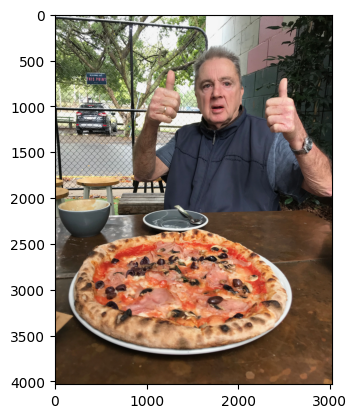

In [ ]:
plt.imshow(custom_image_unit8.permute(1, 2, 0))

So, we have noticed that the type of the image, and the size of the image, it's not what we want. So we have to modify that.

In [ ]:
#1) Change type of the image
custom_image_unit8 = custom_image_unit8.type(torch.float32)/255.
custom_image_unit8

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

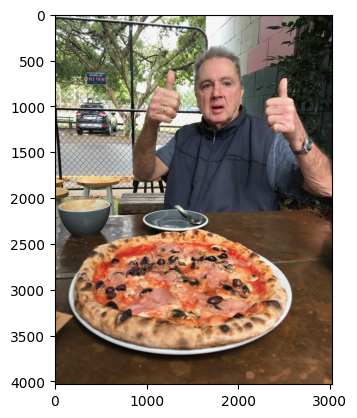

In [ ]:
plt.imshow(custom_image_unit8.permute(1, 2, 0))

In [ ]:
#2.Create transform pipeline to resize the image
custom_transform = transforms.Compose([
    transforms.Resize((64, 64))
])

image_to_test = custom_transform(custom_image_unit8)

In [ ]:
#unsqueeze is necesary in order to add 'batch size'
model_1.eval()
with torch.inference_mode():
  custom_pred = model_1(image_to_test.to(device).unsqueeze(dim=0))
print(class_names[np.argmax(torch.softmax(custom_pred,dim=1)).item()])

pizza


In [ ]:
class_names

['steak', 'sushi', 'pizza']

As we can see, the prediction of the model is... PIZZA! So the model prediction was correct.

## Putting custom image prediction together

In [ ]:
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:list[str],
                        transform:torchvision.transforms=None,
                        device:torch.device=device):
    #load image
    custom_image_unit8 = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255.

    #transform the image
    if transform:
      image_to_test = transform(custom_image_unit8).to(device)

    #make sure the model is on the target device
    model.to(device)

    #turn on inference mode to make prediction
    model.eval()
    with torch.inference_mode():

      custom_pred = model(image_to_test.unsqueeze(dim=0))
      max_prob = torch.softmax(custom_pred,dim=1).max()
      custom_pred_label = class_names[np.argmax(torch.softmax(custom_pred,dim=1)).item()]

    print(f'Prediction: {custom_pred_label}')

    #plot image
    plt.imshow(custom_image_unit8.permute(1, 2, 0))
    plt.title(f'Prediction: {custom_pred_label}, Prob: {max_prob}')
    print()
    plt.axis(False)

Prediction: pizza



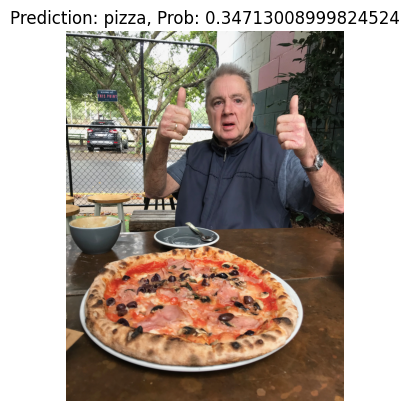

In [ ]:
custom_transform = transforms.Compose([
    transforms.Resize((64, 64))
])

pred_and_plot_image(
    model=model_1,
    image_path=custom_image_path,
    class_names=class_names,
    transform=custom_transform
)

In short,to use your own data you should be sure that 3 requirements are met:
- data in right data type
- data on the same device
- data in the correct shape

THAT'S ALL!!